In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection

Can you describe how the data look in the new spaces you created with the various aglorithms? For PCA, what is the distribution of eigenvalues? For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?

In [3]:
scaler = MinMaxScaler((0,1))
colors_wine = ['red','green','blue','purple', 'pink', 'yellow']
colors_pima = ['red','green']
n_components_range_pima = np.arange(1, 7 + 1)
n_components_range_wine = np.arange(1, 11 + 1)

In [4]:
def get_transform_loss(transformer, X, n_components_range):
    losses = {}
    for n_component in n_components_range:
        transformer.set_params(n_components = n_component)
        X_transformed = transformer.fit_transform(X)
        X_hat = transformer.inverse_transform(X_transformed)
        loss = ((X - X_hat) ** 2).mean().sum()
        losses[n_component] = loss
    return pd.Series(losses)

def get_transform_loss_GRP(transformer, X, n_components_range):
    losses = {}
    
    for n_component in n_components_range:
        transformer.set_params(n_components = n_component)
        X_transformed = transformer.fit_transform(X)
        mean = X.mean(axis=0)
        X_reprojected = np.dot(X_transformed, transformer.components_) + mean
        loss = ((X - X_reprojected) ** 2).mean().sum()
        losses[n_component] = loss
    return pd.Series(losses)


def get_kurtosis(ica, X, n_components_range):
    kurtosis = {}
    for components in n_components_range:
        ica.set_params(n_components=components)
        S = ica.fit_transform(X)
        kurtosis[components] = pd.DataFrame(S).kurt(axis=0).abs().mean()
    return pd.Series(kurtosis)


In [10]:
# pre-processing - centring 

pima = pd.read_csv('./data/Pima.csv').sample(frac = 1) # shuffle pima
assert pima.isnull().sum().sum() == 0
pima_X, pima_Y = pima.iloc[:,0:-1], pima.iloc[:, -1]
pima_Y = pd.Series([1 if label == 2 else 0 for label in pima_Y], name = pima_Y.name) # 0 and 1
pima_X_center= (pima_X - pima_X.mean(axis = 0)) #/ pima_X.std(axis = 0) # centering 
assert np.all(np.array(pima_X_center.sum(axis = 0).values, dtype=np.int32) == 0)

df_pima = pd.concat([pima_X_center, pima_Y], axis = 1)
m_pima, n_pima = pima_X_center.shape

##########################################

wine = pd.read_csv('./data/winequality-red.csv',sep =";").sample(frac = 1) # shuffle wine
assert wine.isnull().sum().sum() == 0
wine_X, wine_Y = wine.iloc[:, 0:-1], wine.iloc[:, -1]
wine_Y = pd.Series([label - 3 for label in wine_Y], name = wine_Y.name) # range 0 to 6
wine_X_center= (wine_X - wine_X.mean(axis = 0))#/ wine_quality_X.std(axis =0)
assert np.all(np.array(wine_X_center.sum(), dtype=np.int32) == 0)

df_wine = pd.concat((wine_X_center, wine_Y), axis =1)
m_wine, n_wine = wine_X_center.shape
df_wine.head(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.919637,0.172179,-0.270976,-0.638806,-0.011467,-4.874922,-12.467792,0.001053,0.198887,-0.098149,-1.022983,4
1,-0.519637,0.352179,-0.270976,0.061194,0.010533,9.125078,20.532208,0.000053,-0.111113,0.021851,-0.622983,2
2,-0.519637,0.232179,-0.230976,-0.238806,0.004533,-0.874922,7.532208,0.000253,-0.051113,-0.008149,-0.622983,2
3,2.880363,-0.247821,0.289024,-0.638806,-0.012467,1.125078,13.532208,0.001253,-0.151113,-0.078149,-0.622983,2
4,-0.919637,0.172179,-0.270976,-0.638806,-0.011467,-4.874922,-12.467792,0.001053,0.198887,-0.098149,-1.022983,2


In [11]:
def plot2D_reprojection(pima_2Dreduced, wine_2Dreduced, pima_Y = pima_Y, wine_Y = wine_Y):

    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(pima_2Dreduced.c1, pima_2Dreduced.c2,
               c=pima_Y, cmap=matplotlib.colors.ListedColormap(colors_pima))
    ax.set_xlabel('c1')
    ax.set_ylabel('c2')

    bx = fig.add_subplot(1,2,2)
    bx.scatter(wine_2Dreduced.c1, wine_2Dreduced.c2,
               c=wine_Y, cmap=matplotlib.colors.ListedColormap(colors_wine))
    bx.set_xlabel('c1')
    bx.set_ylabel('c2')
    return plt

### 2. Dimensionality reduction
#### <u>a. PCA Principal Components Reduction</u>


In [13]:
pima_X_scaled= StandardScaler().fit_transform(pima_X)
wine_X_scaled= StandardScaler().fit_transform(wine_X)

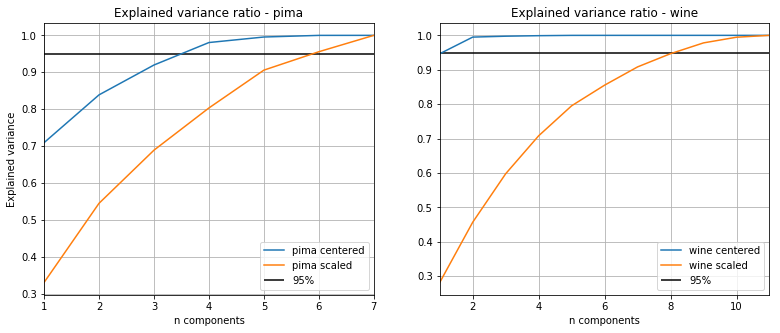

In [14]:
pca_pima_scaled, pca_pima_centered= PCA(), PCA()
pca_wine_scaled, pca_wine_centered = PCA(), PCA()

pca_pima_scaled.fit(pima_X_scaled)
pca_pima_centered.fit(pima_X_center)
pca_wine_scaled.fit(wine_X_scaled)
pca_wine_centered.fit(wine_X_center)

exp_var_cum_pima_centered = pd.Series(
    pca_pima_centered.explained_variance_ratio_.cumsum(),
    index = n_components_range_pima, name = 'pima centered')
exp_var_cum_pima_scaled = pd.Series(
    pca_pima_scaled.explained_variance_ratio_.cumsum(),
    index = n_components_range_pima, name = 'pima scaled')
exp_var_cum_pima = pd.concat((exp_var_cum_pima_centered, exp_var_cum_pima_scaled), axis =1)

exp_var_cum_wine_centered = pd.Series(
    pca_wine_centered.explained_variance_ratio_.cumsum(),
    index = n_components_range_wine, name = 'wine centered')
exp_var_cum_wine_scaled = pd.Series(
    pca_wine_scaled.explained_variance_ratio_.cumsum(),
    index = n_components_range_wine, name = 'wine scaled')
exp_var_cum_wine = pd.concat((exp_var_cum_wine_centered, exp_var_cum_wine_scaled), axis = 1)

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1, title= 'Explained variance ratio - pima')
exp_var_cum_pima.plot(ax = ax)
ax.hlines(0.95, 1, pca_pima_scaled.n_features_ +1, label= '95%')
ax.set_xlabel('n components')
ax.set_ylabel('Explained variance')
ax.legend()
ax.grid(True)

bx = fig.add_subplot(1,2,2, title = 'Explained variance ratio - wine')
exp_var_cum_wine.plot(ax = bx)
bx.hlines(0.95, 1, pca_wine_scaled.n_features_ +1, label= '95%')
bx.legend()
bx.set_xlabel('n components')
bx.grid(True)
plt.show()

<u> Interpretation </u> 

Pima : 4 first components explained more than 95% of the samples variance.

Wine : 2 first components explained more than 95% of the samples' variance.

Note : no scales : explained var way better if not scaled. (center only)

In [16]:
pca_pima, pca_wine = PCA(4), PCA(2)
pima_reduc = pd.DataFrame(pca_pima.fit_transform(pima_X_center),
                          index = pima_X.index, columns = ['c1', 'c2', 'c3', 'c4'])
wine_reduc = pd.DataFrame(pca_wine.fit_transform(wine_X_center),
                          index = wine_X.index, columns = ['c1', 'c2'])

<u> Validation </u>

In [23]:
pca = PCA()
pca_losses_pima = get_transform_loss(pca, pima_X_scaled, n_components_range_pima)
pca_losses_wine = get_transform_loss(pca, wine_X_scaled, n_components_range_wine)
pca_losses = pd.concat((pca_losses_pima, pca_losses_wine), axis =1, keys=['pima', 'wine'])
#pca_losses

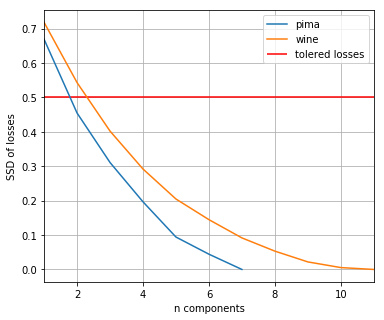

In [35]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,2)
ax.set_ylabel('SSD of losses')
ax.set_xlabel('n components')
ax.hlines(0.5, 1, len(n_components_range_wine) + 1, colors='red', label= 'tolered losses')
pca_losses.plot(ax = ax)
ax.grid(True)
ax.legend()
plt.show()

<u> 2D projection </u>

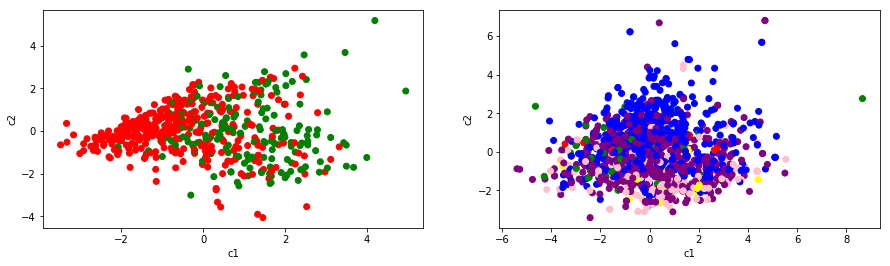

In [25]:
pca = PCA(n_components = 2)
pca_pima_2Dreduced = pd.DataFrame(pca.fit_transform(pima_X_scaled), columns=['c1', 'c2'])
pca_wine_2Dreduced = pd.DataFrame(pca.fit_transform(wine_X_scaled), columns=['c1', 'c2'])

plt = plot2D_reprojection(pca_pima_2Dreduced, pca_wine_2Dreduced)
plt.show()

Pima : c1 and c2 are discriminating but intersec clusters very strong

Wine : c1 and c2 are not great for discriminating classes

#### <u>b. ICA Independent Components Analysis </u>


goal is to find a linear representation of nongaussian data so
that the components are statistically independent, or as independent as possible. Such a representation seems to
capture the essential structure of the data in many applications, including feature extraction and signal separation.


In [26]:
# need to Center and Scale to unit variance.
pima_X_scaled= StandardScaler().fit_transform(pima_X)
wine_X_scaled= StandardScaler().fit_transform(wine_X)

ica = FastICA(random_state=5, max_iter=1000, tol=1e-2)
# return mean of kurtosis
ica_kurto_pima = get_kurtosis(ica, pima_X_scaled, n_components_range_pima)
ica_kurto_wine = get_kurtosis(ica, wine_X_scaled, n_components_range_wine)
ica_kurtos = pd.concat((ica_kurto_pima, ica_kurto_wine), axis =1, keys=['pima', 'wine'])
# return sum of losses from all original features
ica_losses_pima = get_transform_loss(ica, pima_X_scaled, n_components_range_pima)
ica_losses_wine = get_transform_loss(ica, wine_X_scaled, n_components_range_wine)
ica_losses = pd.concat((ica_losses_pima, ica_losses_wine), axis =1, keys=['pima', 'wine'])
ica_losses

,pima,wine
1,6.690754e-01,7.182607e-01
2,4.547381e-01,5.431780e-01
3,3.108776e-01,4.022195e-01
4,1.965805e-01,2.919256e-01
5,9.415894e-02,2.047173e-01
6,4.432176e-02,1.447529e-01
7,5.079296e-31,9.168094e-02
8,NaN,5.323033e-02
9,NaN,2.189923e-02
10,NaN,5.414392e-03


<u> Validation </u>

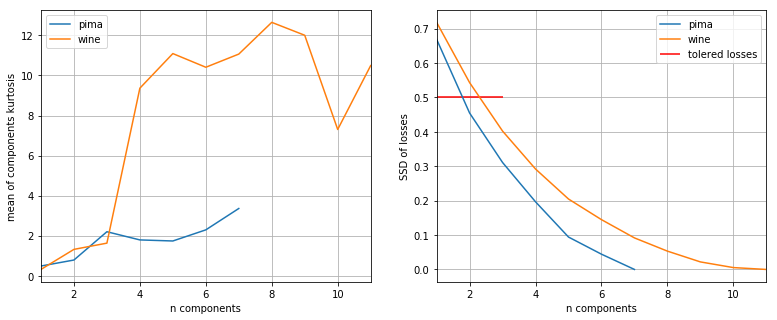

In [40]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.set_ylabel('mean of components kurtosis')
ax.set_xlabel('n components')
ica_kurtos.plot(ax = ax)
ax.grid(True)
ax.legend()

bx = fig.add_subplot(1,2,2)
bx.set_ylabel('SSD of losses')
bx.set_xlabel('n components')
bx.hlines(0.5, 1, ica.n_components +1, colors='red', label= 'tolered losses')
ica_losses.plot(ax = bx)
bx.grid(True)
bx.legend()
plt.show()

Both losses are decresing almost steadily with the num of components (assuming h = 0.3 is acceptable losses).

-> Trade off : smalles possible - highest kurtosis and bellow tolered losses

Choose n comp = 4 for wine : very higher kurtosis
Choose n comp = 3 for pima : higher kurtosis

<u> 2D projection </u>

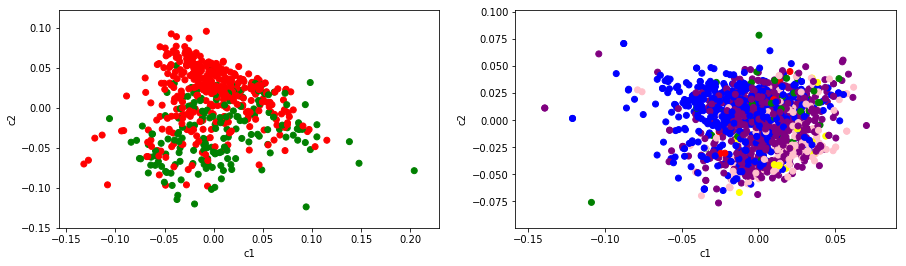

In [28]:
ica = ica.set_params(n_components = 2)
ica_pima_2Dreduced = pd.DataFrame(ica.fit_transform(pima_X_scaled), columns=['c1', 'c2'])
ica_wine_2Dreduced = pd.DataFrame(ica.fit_transform(wine_X_scaled), columns=['c1', 'c2'])

plt = plot2D_reprojection(ica_pima_2Dreduced, ica_wine_2Dreduced)
plt.show()

#### c. <u> Randomized Projections </u>

The dimensions and distribution of random projections matrices are controlled so as to preserve the pairwise distances between any two samples of the dataset. Thus random projection is a suitable approximation technique for distance based method (kmeans & EM !)

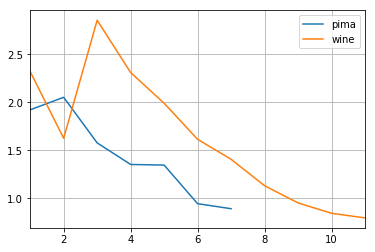

In [29]:
randp = GaussianRandomProjection(random_state=7)
randp_losses_pima = get_transform_loss_GRP(randp, pima_X_scaled, n_components_range_pima)
randp_losses_wine = get_transform_loss_GRP(randp, wine_X_scaled, n_components_range_wine)
randp_losses = pd.concat((randp_losses_pima, randp_losses_wine), axis = 1, keys=['pima', 'wine'])
randp_losses.plot(grid = True)
plt.show()

Lots of variation: show variance ? 

<u> Projection 2D </u>

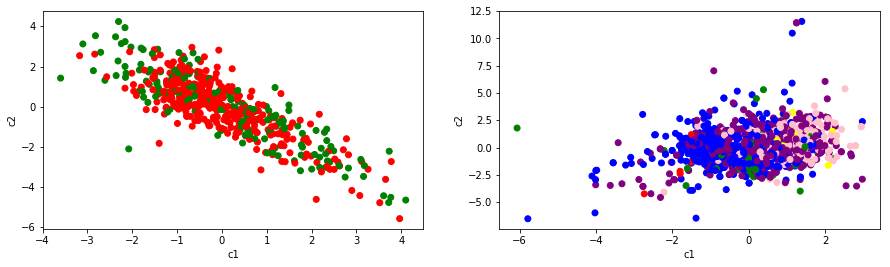

In [385]:
randp_pima = randp.set_params(n_components = 2)
randp_pima_2Dreduced = pd.DataFrame(randp_pima.fit_transform(pima_X_scaled), columns=['c1', 'c2'])
randp_wine = randp.set_params(n_components = 2)
randp_wine_2Dreduced = pd.DataFrame(randp_wine.fit_transform(wine_X_scaled), columns=['c1', 'c2'])

plt = plot2D_reprojection(randp_pima_2Dreduced, randp_wine_2Dreduced)
plt.show()

#### d. <u> Factor Analysis </u>

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

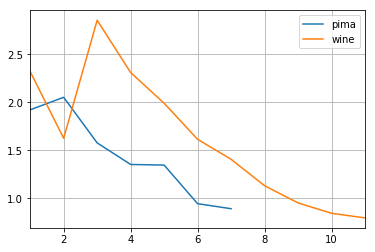

In [41]:
fa = FactorAnalysis(random_state = 6)
fa_losses_pima = get_transform_loss_GRP(fa, pima_X_scaled, n_components_range_pima)
fa_losses_wine = get_transform_loss_GRP(fa, wine_X_scaled, n_components_range_wine)
fa_losses = pd.concat((randp_losses_pima, randp_losses_wine), axis = 1, keys=['pima', 'wine'])
fa_losses.plot(grid = True)
plt.show()

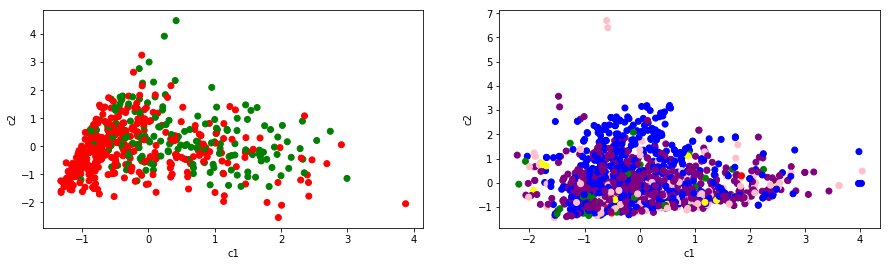

In [42]:
fa_2D = fa.set_params(n_components = 2)
fa_pima_2Dreduced = pd.DataFrame(fa_2D.fit_transform(pima_X_scaled), columns=['c1', 'c2'])
fa_wine_2Dreduced = pd.DataFrame(fa_2D.fit_transform(wine_X_scaled), columns=['c1', 'c2'])

plt = plot2D_reprojection(fa_pima_2Dreduced, fa_wine_2Dreduced)
plt.show()